In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

数据预处理

In [2]:
from  torchvision import transforms, datasets


transform= transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,),(0.3081,))])

下载,加载数据集

In [3]:
import torch

train_dataset= datasets.MNIST(root='./data', 
                              train=True, 
                              download=True, 
                              transform=transform)
test_dataset= datasets.MNIST(root='./data',
                             train=False,
                             download=True,
                             transform=transform)

train_loader= torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size= 64,
                                          shuffle=True)
test_loader= torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size= 1000,
                                         shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:33<00:00, 292915.24it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 32635.97it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:21<00:00, 77282.73it/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 15096.81it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [20]:
# -------------------- 2. 定义神经网络模型 --------------------
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 输入通道1，输出32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)  # 经过两次池化后尺寸：28→14→7
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))    # [B,32,28,28]
        x = self.pool(x)                 # [B,32,14,14]
        x = torch.relu(self.conv2(x))    # [B,64,14,14]
        x = self.pool(x)                 # [B,64,7,7]
        x = x.view(-1, 64*7*7)           # 展平
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNIST_CNN()

# -------------------- 3. 训练配置 --------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------- 4. 训练循环 --------------------
def train(epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # 打印训练进度
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | "
              f"Accuracy: {100*correct/total:.2f}%")

In [21]:
train(epochs=10)

Epoch [1/10] | Loss: 0.1607 | Accuracy: 94.93%
Epoch [2/10] | Loss: 0.0640 | Accuracy: 98.01%
Epoch [3/10] | Loss: 0.0476 | Accuracy: 98.44%
Epoch [4/10] | Loss: 0.0376 | Accuracy: 98.80%
Epoch [5/10] | Loss: 0.0337 | Accuracy: 98.86%
Epoch [6/10] | Loss: 0.0281 | Accuracy: 99.09%
Epoch [7/10] | Loss: 0.0271 | Accuracy: 99.11%
Epoch [8/10] | Loss: 0.0219 | Accuracy: 99.30%
Epoch [9/10] | Loss: 0.0210 | Accuracy: 99.34%
Epoch [10/10] | Loss: 0.0193 | Accuracy: 99.32%


模型评估

In [22]:
def evaluate():
    # 将模型设置为评估模式，这会影响某些层（如Dropout和BatchNorm）的行为
    model.eval()
    # 初始化正确预测的计数器
    correct = 0
    # 初始化测试样本的总数计数器
    total = 0
    # 使用torch.no_grad()上下文管理器，以避免在评估过程中计算梯度，节省内存和计算资源
    with torch.no_grad():
        # 遍历测试数据集
        for images, labels in test_loader:
            # 将图像和标签移动到指定的设备（如GPU）
            images, labels = images.to(device), labels.to(device)
            # 通过模型获取输出
            outputs = model(images)
            # 使用torch.max获取每个样本的预测类别（返回最大值的索引）
            _, predicted = torch.max(outputs.data, 1)
            # 更新测试样本的总数
            total += labels.size(0)
            # 计算预测正确的样本数，并转换为Python标量
            correct += (predicted == labels).sum().item()

    # 打印测试集的准确率，格式化为两位小数
    print(f"Test Accuracy: {100*correct/total:.2f}%")

evaluate()

Test Accuracy: 99.29%


In [23]:
def show_predictions():
    # 获取测试数据加载器的迭代器
    data_iter = iter(test_loader)
    # 从迭代器中获取下一批数据，包括图像和标签
    images, labels = next(data_iter)
    # 将图像和标签移动到指定的设备（如GPU）
    images, labels = images.to(device), labels.to(device)
    
    # 使用模型对图像进行预测
    outputs = model(images)
    # 获取预测结果，torch.max返回每个样本的最大值及其索引
    # _, predicted 表示我们只关心最大值的索引（即预测的类别）
    _, predicted = torch.max(outputs, 1)
    
    # 可视化前6个样本
    fig = plt.figure(figsize=(10,4))
    for idx in range(6):
        ax = fig.add_subplot(2, 3, idx+1)
        img = images[idx].cpu().numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {predicted[idx].item()}, True: {labels[idx].item()}")
        ax.axis('off')
    plt.show()

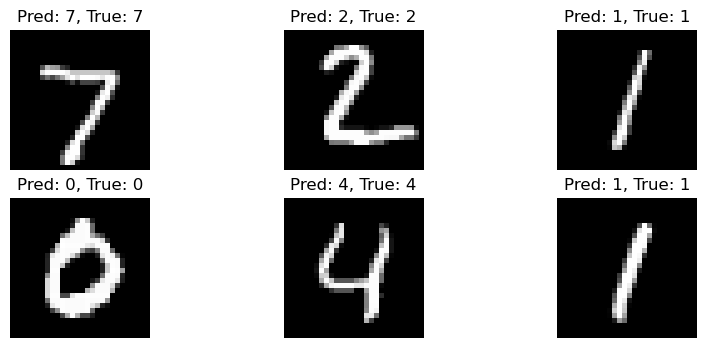

In [24]:
show_predictions()